In [10]:
# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline
from sklearn.impute import SimpleImputer
# sklearn packages
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans



ModuleNotFoundError: No module named 'sklearn'

In [2]:
file_path = './CC_LCL-FullData.csv'

df=pd.read_csv(file_path, nrows=100000)
df


,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0
...,...,...,...,...
99995,MAC000006,Std,2012-07-29 10:30:00.0000000,0.031
99996,MAC000006,Std,2012-07-29 11:00:00.0000000,0.018
99997,MAC000006,Std,2012-07-29 11:30:00.0000000,0.045
99998,MAC000006,Std,2012-07-29 12:00:00.0000000,0.014


In [3]:
df = df[df['KWH/hh (per half hour) '] != 0]
df['KWH/hh (per half hour) '].dropna()


df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

# Remove rows where "KWH/hh (per half hour)" is equal to or close to zero
df = df[df['KWH/hh (per half hour) '] != 0]
df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
21,MAC000002,Std,2012-10-12 11:30:00.0000000,0.143
22,MAC000002,Std,2012-10-12 12:00:00.0000000,0.663
23,MAC000002,Std,2012-10-12 12:30:00.0000000,0.256
24,MAC000002,Std,2012-10-12 13:00:00.0000000,0.155
25,MAC000002,Std,2012-10-12 13:30:00.0000000,0.199
...,...,...,...,...
99995,MAC000006,Std,2012-07-29 10:30:00.0000000,0.031
99996,MAC000006,Std,2012-07-29 11:00:00.0000000,0.018
99997,MAC000006,Std,2012-07-29 11:30:00.0000000,0.045
99998,MAC000006,Std,2012-07-29 12:00:00.0000000,0.014


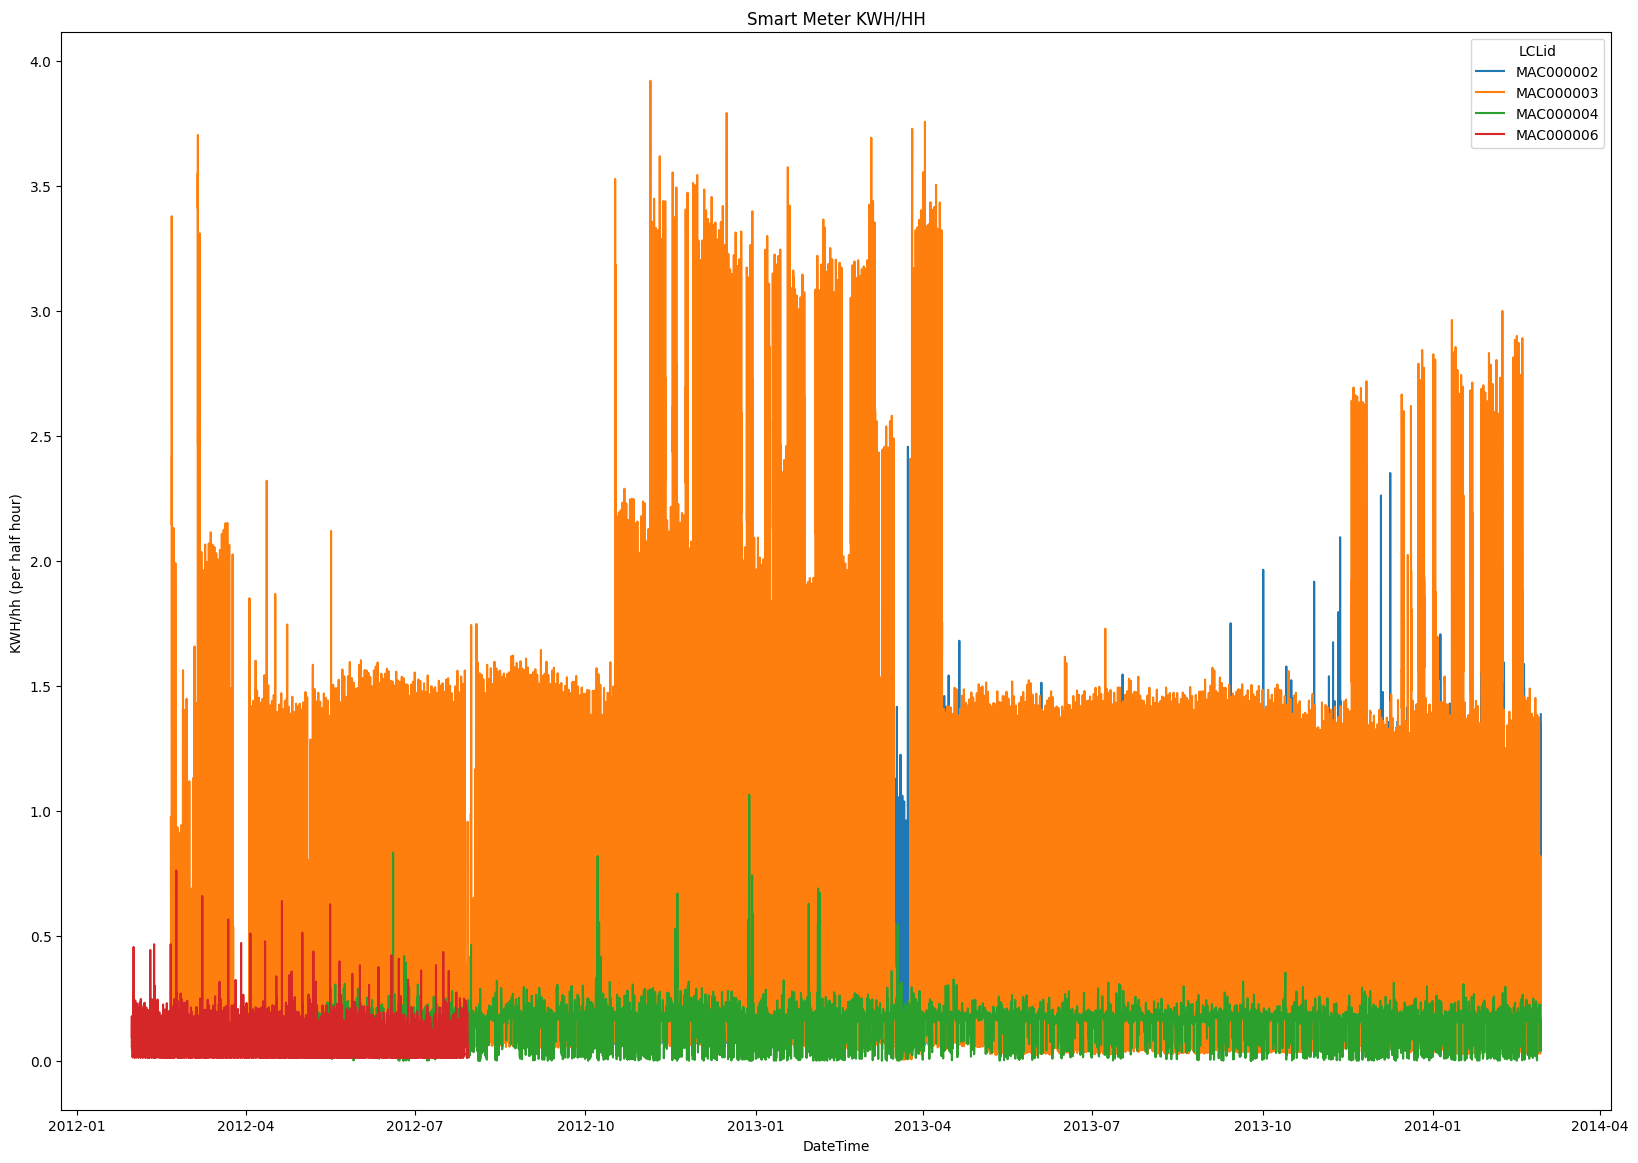

In [4]:
%matplotlib inline

df['DateTime'] = pd.to_datetime(df['DateTime'])

plt.figure(figsize=(20, 14))
sns.lineplot(x='DateTime', y='KWH/hh (per half hour) ', hue='LCLid', data=df)

plt.xlabel('DateTime')
plt.ylabel('KWH/hh (per half hour) ')
plt.title('Smart Meter KWH/HH')

plt.show()


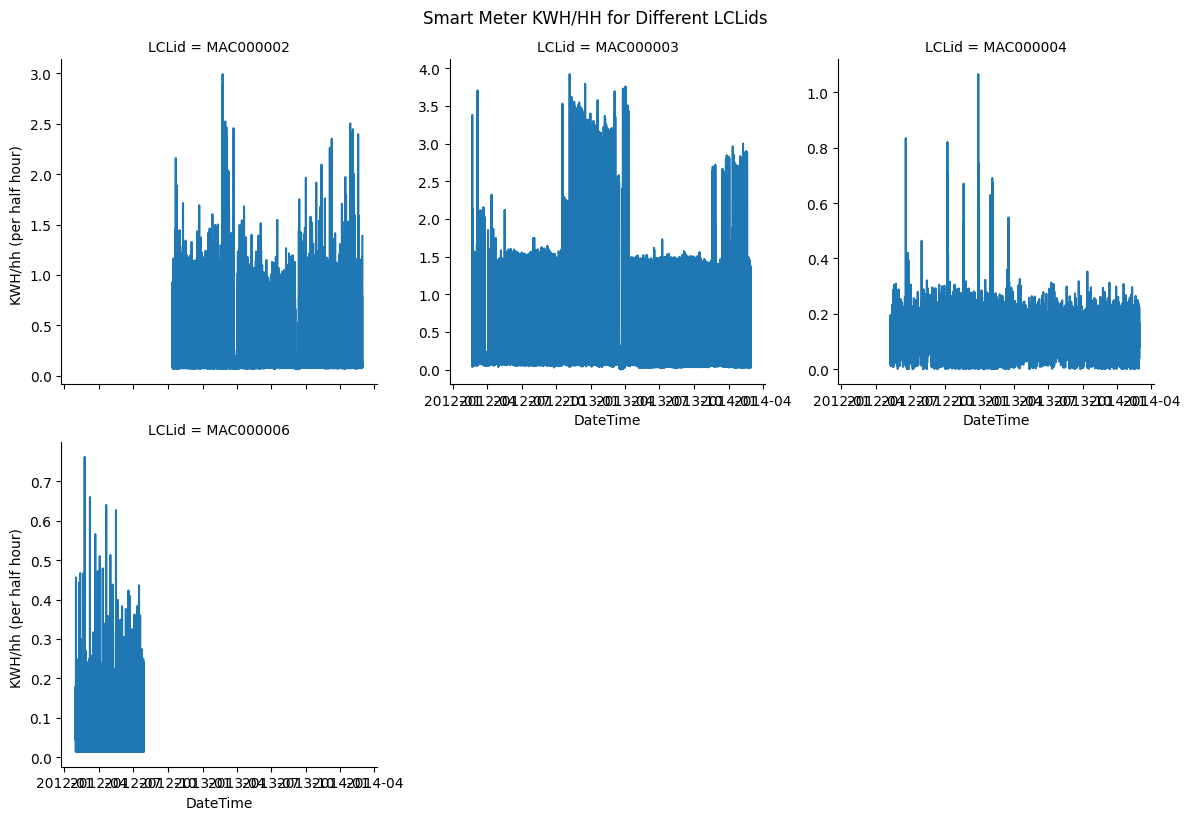

In [5]:
%matplotlib inline

# Assuming your data is stored in a DataFrame named df
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set up the FacetGrid
g = sns.FacetGrid(df, col="LCLid", col_wrap=3, height=4, sharey=False)
g.map(sns.lineplot, 'DateTime', 'KWH/hh (per half hour) ')

# Set common labels and title
g.set_axis_labels("DateTime", "KWH/hh (per half hour) ")
g.fig.suptitle('Smart Meter KWH/HH for Different LCLids', y=1.02)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


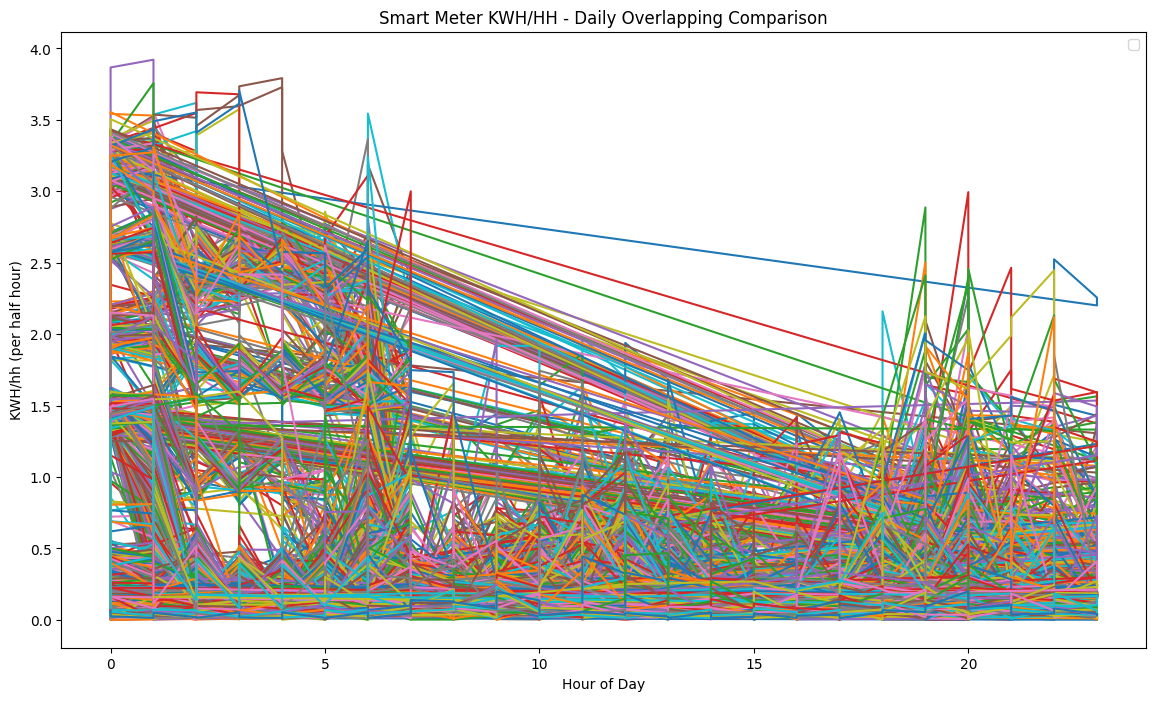

In [6]:
%matplotlib inline

# Assuming your data is stored in a DataFrame named df
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract date from DateTime
df['Date'] = df['DateTime'].dt.date

# Set up the plot
plt.figure(figsize=(14, 8))

# Iterate over unique dates and plot each day's data on the same axis
for date in df['Date'].unique():
    date_data = df[df['Date'] == date]
    plt.plot(date_data['DateTime'].dt.hour, date_data['KWH/hh (per half hour) '])

# Set common labels and title
plt.xlabel('Hour of Day')
plt.ylabel('KWH/hh (per half hour)')
plt.title('Smart Meter KWH/HH - Daily Overlapping Comparison')
plt.legend()

plt.show()


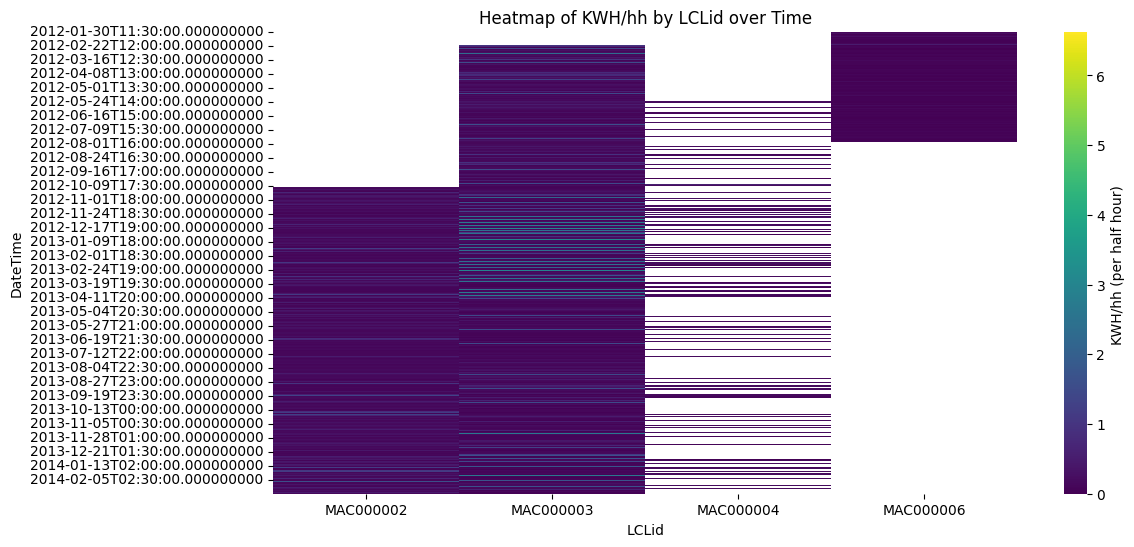

In [7]:

df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

df['DateTime'] = pd.to_datetime(df['DateTime'])

heatmap_data = df.pivot_table(index='DateTime', columns='LCLid', values='KWH/hh (per half hour) ', aggfunc='sum')

heatmap_data = heatmap_data.dropna(axis=0, how='all')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'KWH/hh (per half hour) '})

plt.xlabel('LCLid')
plt.ylabel('DateTime')
plt.title('Heatmap of KWH/hh by LCLid over Time')

plt.show()

In [8]:
numeric_columns = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_columns]

# Use SimpleImputer to fill missing values with mean (you can choose other strategies)
imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)

# Extract the numeric values and scale/normalize the profiles
np_scaled = StandardScaler().fit_transform(df_numeric_imputed.values)

# define the number of clusters, fit the model to the scaled profiles and predict
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
np_preds = kmeans.fit_predict(np_scaled)

# create the figure
fig, ax = plt.subplots(int(math.ceil(n_clusters/2)), 2, figsize=(8, 8))
ax = ax.flatten()

# to visualize the clusters, loop over the clusters (i.e., unique labels of predictions)
for idx in np.unique(np_preds):

  # get the indices of the elements (rows) that belong to the same cluster
  indices = np.where(np_preds == idx)[0]

  # use the indices to get the relevant profiles
  np_profs = np_scaled[indices, :].T

  # plot all profiles of a cluster and their mean profile
  ax[idx].plot(np_profs, color='blue', alpha=0.2, linewidth=0.5)
  ax[idx].plot(np.mean(np_profs, axis=1), color='black', linewidth=2)

  # adjust additional formatting
  ax[idx].set_ylabel('Normalized Energy')
  ax[idx].set_xlabel('Time of Day')
  ax[idx].set_xticks(ax[idx].get_xticks())
  ax[idx].set_xticklabels(['{:02d}:{:02d}'.format(int(e/4), int(e%4)) for e in ax[idx].get_xticks()])
  ax[idx].set_title('Cluster {} - Observations: {}'.format(idx, len(indices)))
  ax[idx].set_xlim(0, 96)

# show
plt.tight_layout()
plt.show()

NameError: name 'SimpleImputer' is not defined